In [2]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pathlib import Path
"""
Script para analizar sentimiento con VADER y guardar los resultados en un nuevo CSV.
"""

# 1) Carga tu CSV original
#csvFile = 'data/Twitter_Data.csv';
csvFile = Path("data") / "Twitter_Data.csv"
df = pd.read_csv(csvFile)

# 2) Inicializa VADER
analyzer = SentimentIntensityAnalyzer()

# 3) Aplica al texto limpio
df['sentiment_cont'] = df['clean_text'].apply(
    lambda txt: analyzer.polarity_scores(str(txt))['compound']
)

# 4) Quédanos sólo con la columna numérica
df_num = df[['sentiment_cont']]

# 5) Guarda el CSV de sólo scores
#output_path = 'data\Twitter_Data_scores.csv'
output_path = Path("data") / "Twitter_Data_scores.csv"
df_num.to_csv(output_path, index=False)

print(df_num.head())

   sentiment_cont
0          0.5267
1         -0.4019
2          0.7096
3         -0.0713
4          0.4754


In [3]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pathlib import Path

"""
Script para analizar sentimiento con VADER, omitir NaN y vacíos,
guardar scores y generar una muestra representativa de 500 opiniones.
"""

# 1) Carga tu CSV original
csvFile = Path("data") / "Twitter_Data.csv"
df = pd.read_csv(csvFile)

# 2) Inicializa VADER
analyzer = SentimentIntensityAnalyzer()

# 3) Calcula sentimiento SOLO donde clean_text es texto no vacío; el resto queda NaN y se eliminará
def vader_compound_or_na(x):
    # Omitimos NaN y strings vacíos (tras quitar espacios)
    if isinstance(x, str) and x.strip() != "":
        return analyzer.polarity_scores(x)["compound"]
    return pd.NA

df["sentiment_cont"] = df["clean_text"].apply(vader_compound_or_na)

# 4) Elimina filas sin score (NaN en sentiment_cont)
df_valid = df.dropna(subset=["sentiment_cont"]).copy()

# 5) Reescalado lineal a [0, 1]
# compound = -1 → 0   (muy negativo)
# compound =  0 → 0.5 (neutral)
# compound =  1 → 1   (muy positivo)
df_valid["sentiment_scaled"] = (df_valid["sentiment_cont"] + 1) / 2

# 6) Guarda CSV solo con scores (ya sin NaN)
scores_path = Path("data") / "Twitter_Data_scores.csv"
df_valid[[ "sentiment_scaled"]].to_csv(scores_path, index=False)

# 7) Muestra representativa de 300 opiniones (estratificada por cuantiles)
n_target = 300
if len(df_valid) <= n_target:
    sample_df = df_valid.copy()
else:
    # Estratos por cuantiles (deciles). duplicates='drop' evita errores con empates
    bins = pd.qcut(df_valid["sentiment_cont"], q=10, duplicates="drop")
    df_tmp = df_valid.copy()
    df_tmp["__bin__"] = bins

    counts = df_tmp["__bin__"].value_counts().sort_index()
    props = counts / counts.sum()
    per_bin = (props * n_target).round().astype(int)

    # Ajuste para sumar exactamente n_target
    diff = n_target - per_bin.sum()
    if diff != 0:
        residuals = (props * n_target) - (props * n_target).round()
        order = residuals.sort_values(ascending=(diff < 0)).index
        for b in order:
            if diff == 0:
                break
            per_bin.loc[b] += 1 if diff > 0 else -1
            diff += -1 if diff > 0 else 1

    parts = []
    for b, k in per_bin.items():
        g = df_tmp[df_tmp["__bin__"] == b]
        if k > 0:
            k = min(k, len(g))
            parts.append(g.sample(n=k, random_state=42))
    sample_df = pd.concat(parts, ignore_index=True)

    # Seguridad: recorta/complete para llegar a 300 exactos
    if len(sample_df) > n_target:
        sample_df = sample_df.sample(n=n_target, random_state=42).reset_index(drop=True)
    elif len(sample_df) < n_target:
        faltan = n_target - len(sample_df)
        resto = df_valid.loc[~df_valid.index.isin(sample_df.index)]
        extra = resto.sample(n=faltan, random_state=42)
        sample_df = pd.concat([sample_df, extra], ignore_index=True)

    sample_df = sample_df.drop(columns="__bin__", errors="ignore")

# 8) Guarda la muestra con texto y scores
sample_path = Path("data") / "Twitter_Data_sample300.csv"
cols_to_save = [c for c in ["clean_text", "sentiment_cont", "sentiment_scaled"] if c in sample_df.columns]
sample_df.to_csv(sample_path, index=False, columns=cols_to_save)

# 9) Vistazo rápido
print("Scores (primeras filas, sin NaN):")
print(df_valid[["sentiment_cont", "sentiment_scaled"]].head(), "\n")
print(f"Muestra guardada en: {sample_path} (tamaño={len(sample_df)})")
print(sample_df[cols_to_save].head())


Scores (primeras filas, sin NaN):
  sentiment_cont sentiment_scaled
0         0.5267          0.76335
1        -0.4019          0.29905
2         0.7096           0.8548
3        -0.0713          0.46435
4         0.4754           0.7377 

Muestra guardada en: data\Twitter_Data_sample300.csv (tamaño=300)
                                          clean_text sentiment_cont  \
0  population world769 crore india136 crore but r...        -0.6652   
1  means they have already cheated can correct th...        -0.8689   
2  worked its heart out for rich crooks\nmodi had...        -0.7543   
3  now see the brutality indians and their hate a...        -0.8779   
4  ohh slave unknown how earth rotation happens s...        -0.8023   

  sentiment_scaled  
0           0.1674  
1          0.06555  
2          0.12285  
3          0.06105  
4          0.09885  


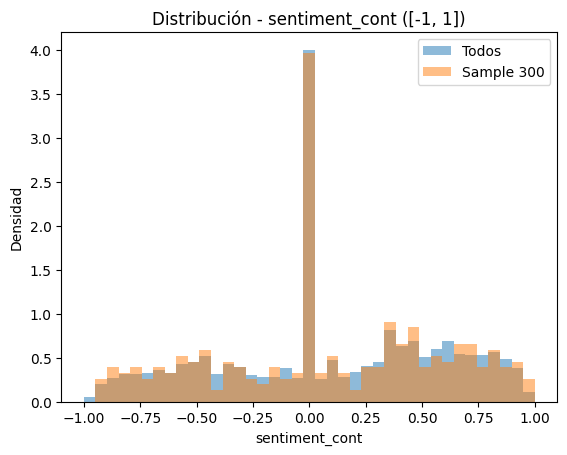

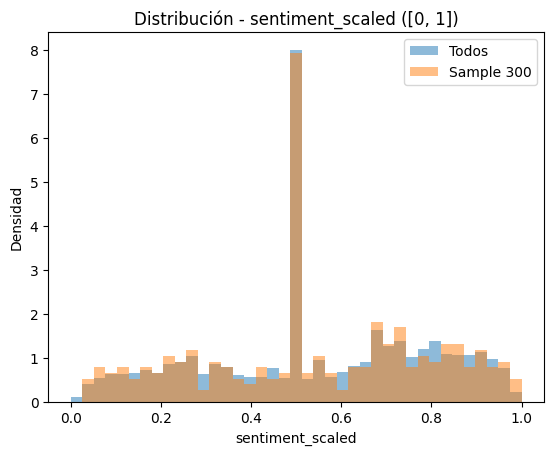

Todos - sentiment_cont
count     162975.0
unique      9882.0
top            0.0
freq       32853.0
Name: sentiment_cont, dtype: float64 

Sample - sentiment_cont
count    300.000000
mean       0.086720
std        0.503575
min       -0.931300
10%       -0.649710
25%       -0.278900
50%        0.000000
75%        0.477775
90%        0.757900
max        0.964300
Name: sentiment_cont, dtype: float64 

Sample - sentiment_scaled
count    300.000000
mean       0.543360
std        0.251787
min        0.034350
10%        0.175145
25%        0.360550
50%        0.500000
75%        0.738888
90%        0.878950
max        0.982150
Name: sentiment_scaled, dtype: float64


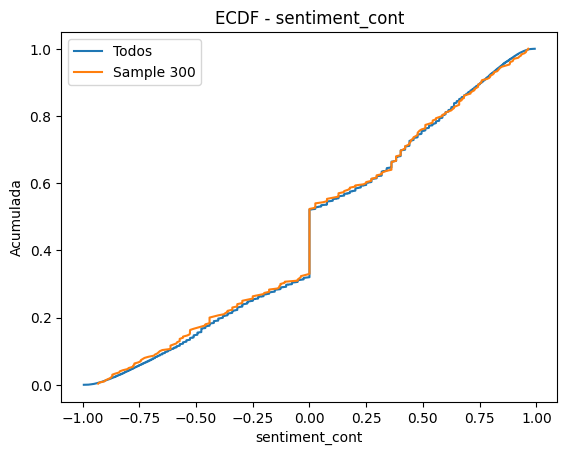

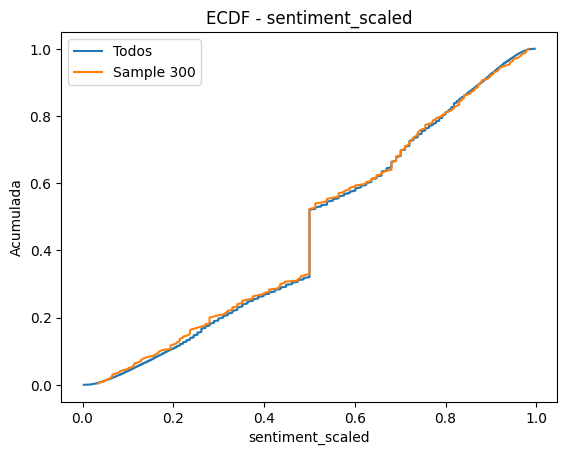

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Si no tienes sample_df en memoria, cárgalo:
sample_df = pd.read_csv("data/Twitter_Data_sample300.csv")

# --- Para sentiment_cont ---
bins = np.linspace(-1, 1, 40)

plt.figure()
plt.hist(df_valid["sentiment_cont"], bins=bins, alpha=0.5, density=True, label="Todos")
plt.hist(sample_df["sentiment_cont"], bins=bins, alpha=0.5, density=True, label="Sample 300")
plt.title("Distribución - sentiment_cont ([-1, 1])")
plt.xlabel("sentiment_cont")
plt.ylabel("Densidad")
plt.legend()
plt.show()

# --- Para sentiment_scaled ---
bins_s = np.linspace(0, 1, 40)

plt.figure()
plt.hist(df_valid["sentiment_scaled"], bins=bins_s, alpha=0.5, density=True, label="Todos")
plt.hist(sample_df["sentiment_scaled"], bins=bins_s, alpha=0.5, density=True, label="Sample 300")
plt.title("Distribución - sentiment_scaled ([0, 1])")
plt.xlabel("sentiment_scaled")
plt.ylabel("Densidad")
plt.legend()
plt.show()

print("Todos - sentiment_cont")
print(df["sentiment_cont"].describe(percentiles=[.1,.25,.5,.75,.9]), "\n")

print("Sample - sentiment_cont")
print(sample_df["sentiment_cont"].describe(percentiles=[.1,.25,.5,.75,.9]), "\n")

print("Sample - sentiment_scaled")
print(sample_df["sentiment_scaled"].describe(percentiles=[.1,.25,.5,.75,.9]))
import numpy as np
import matplotlib.pyplot as plt
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# sentiment_cont
x_all, y_all = ecdf(df["sentiment_cont"].dropna().values)
x_smp, y_smp = ecdf(sample_df["sentiment_cont"].dropna().values)

plt.figure()
plt.plot(x_all, y_all, label="Todos")
plt.plot(x_smp, y_smp, label="Sample 300")
plt.title("ECDF - sentiment_cont")
plt.xlabel("sentiment_cont")
plt.ylabel("Acumulada")
plt.legend()
plt.show()

# sentiment_scaled
x_all_s, y_all_s = ecdf(df_valid["sentiment_scaled"].dropna().values)
x_smp_s, y_smp_s = ecdf(sample_df["sentiment_scaled"].dropna().values)

plt.figure()
plt.plot(x_all_s, y_all_s, label="Todos")
plt.plot(x_smp_s, y_smp_s, label="Sample 300")
plt.title("ECDF - sentiment_scaled")
plt.xlabel("sentiment_scaled")
plt.ylabel("Acumulada")
plt.legend()
plt.show()


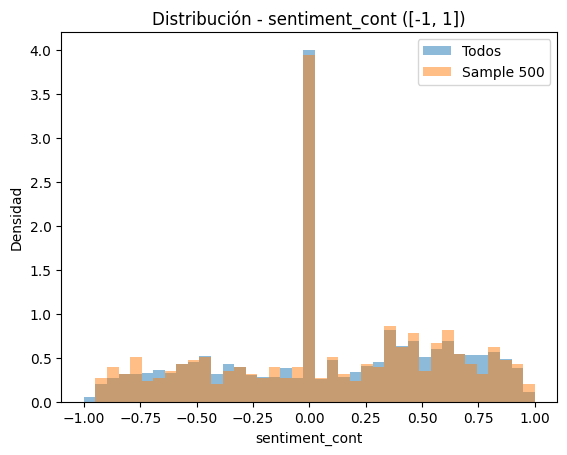

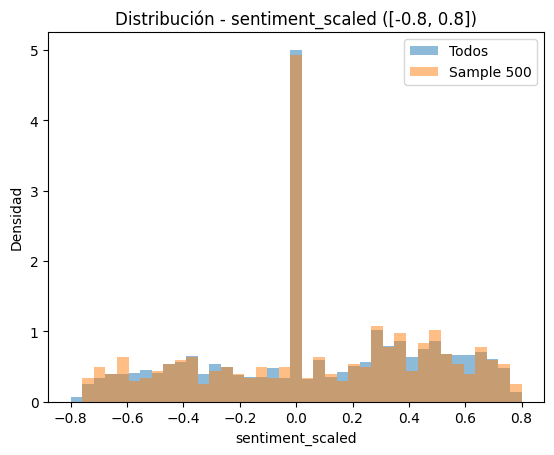

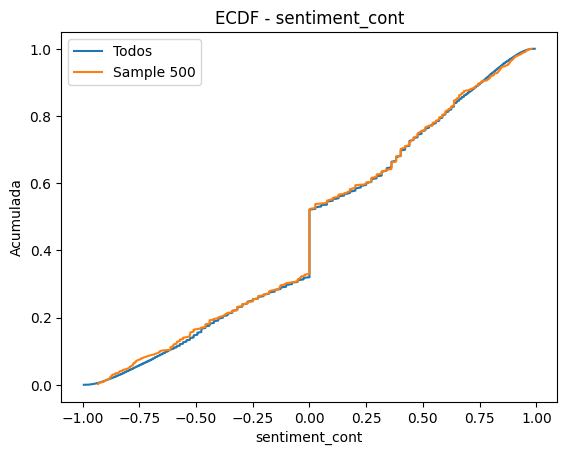

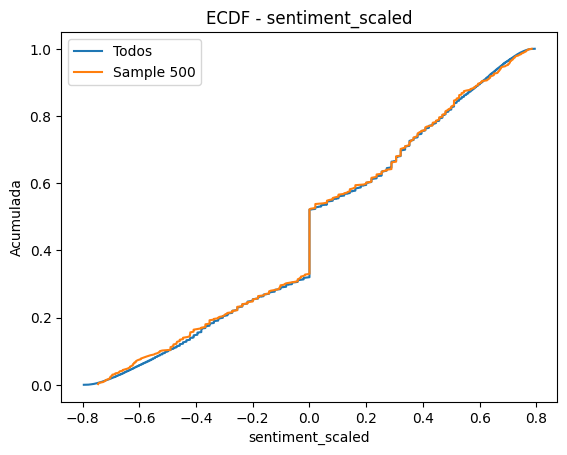

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def clean_numeric(series: pd.Series) -> np.ndarray:
    # Convierte a numérico, fuerza NaN cuando no se pueda y elimina faltantes
    s = pd.to_numeric(series, errors="coerce")
    return s.dropna().to_numpy(dtype=float)

# Si no los tienes en memoria, recupera:
df = pd.read_csv("data/Twitter_Data_scores.csv")  # si guardaste sólo scores
# sample_df = pd.read_csv("data/Twitter_Data_sample500.csv")

# Limpia las columnas
all_cont   = clean_numeric(df["sentiment_cont"])
samp_cont  = clean_numeric(sample_df["sentiment_cont"])
all_scaled = clean_numeric(df["sentiment_scaled"])
samp_scaled= clean_numeric(sample_df["sentiment_scaled"])

# --- Histogramas ---
bins_cont = np.linspace(-1, 1, 40)
plt.figure()
plt.hist(all_cont,  bins=bins_cont, alpha=0.5, density=True, label="Todos")
plt.hist(samp_cont, bins=bins_cont, alpha=0.5, density=True, label="Sample 500")
plt.title("Distribución - sentiment_cont ([-1, 1])")
plt.xlabel("sentiment_cont"); plt.ylabel("Densidad"); plt.legend(); plt.show()

bins_scaled = np.linspace(-0.8, 0.8, 40)
plt.figure()
plt.hist(all_scaled,  bins=bins_scaled, alpha=0.5, density=True, label="Todos")
plt.hist(samp_scaled, bins=bins_scaled, alpha=0.5, density=True, label="Sample 500")
plt.title("Distribución - sentiment_scaled ([-0.8, 0.8])")
plt.xlabel("sentiment_scaled"); plt.ylabel("Densidad"); plt.legend(); plt.show()

# --- ECDFs ---
def ecdf(arr):
    x = np.sort(arr)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_all, y_all   = ecdf(all_cont)
x_smp, y_smp   = ecdf(samp_cont)
plt.figure()
plt.plot(x_all, y_all, label="Todos"); plt.plot(x_smp, y_smp, label="Sample 500")
plt.title("ECDF - sentiment_cont"); plt.xlabel("sentiment_cont"); plt.ylabel("Acumulada"); plt.legend(); plt.show()

x_all_s, y_all_s = ecdf(all_scaled)
x_smp_s, y_smp_s = ecdf(samp_scaled)
plt.figure()
plt.plot(x_all_s, y_all_s, label="Todos"); plt.plot(x_smp_s, y_smp_s, label="Sample 500")
plt.title("ECDF - sentiment_scaled"); plt.xlabel("sentiment_scaled"); plt.ylabel("Acumulada"); plt.legend(); plt.show()
